In [2]:
%load_ext autoreload
%autoreload 2
import os
import data_prep as dp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import imgaug as ia
import imgaug.augmenters as iaa
import cv2

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
# Set the environment seed for Python
os.environ['PYTHONHASHSEED'] = '0'

seed=101

# Set seed for Numpy
np.random.seed(seed)

### Train

In [4]:
# Find and label each image according to class
filer=dp.Files()

normal = filer.find_files('all_xrays/train/normal', "0001").files
virus = filer.find_files('all_xrays/train/virus', "virus").files
bacteria = filer.find_files('all_xrays/train/bacteria', "bacteria").files

pneumonia = (virus+bacteria)

files_dict = {'normal':normal,'pneumonia':pneumonia}
training_dataset = []
iteration=-1

for files in files_dict:
    iteration+=1
    for file in files_dict[files]:
        training_dataset.append((file,iteration))
        

df_train = pd.DataFrame(training_dataset, columns=("file","class"))
df_train['class'] = df_train['class'].astype(dtype='category')

df_train['class'].value_counts() # 0 = Bacterial ; 1 = Viral ; 2 = Normal

1    3375
0    1249
Name: class, dtype: int64

### Validation

In [22]:
# Find and label each image according to class

normal = filer.find_files('all_xrays/val/normal', "0001").files
virus = filer.find_files('all_xrays/val/virus', "virus").files
bacteria = filer.find_files('all_xrays/val/bacteria', "bacteria").files

files_dict = {'normal':normal,'virus':virus,'bacteria':bacteria}
validation_dataset = []
iteration=-1

# Create list of file and corresponding label
for files in files_dict:
    iteration+=1
    for file in files_dict[files]:
        validation_dataset.append((file,iteration))

# Convert list to dataframe        
df_val = pd.DataFrame(validation_dataset, columns=("file","class"))
df_val['class'] = df_val['class'].astype(dtype='category')

# Check the number of files in each class 
df_val['class'].value_counts() # 2 = Bacterial ; 1 = Viral ; 0 = Normal

2    27
0    15
1    14
Name: class, dtype: int64

In [25]:
directory='all_xrays/val/'
subfolders=['normal','virus','bacteria']
class_labels=[0,1,1]

val_data, val_labels = dp.image_data_and_labels('.jpeg',directory,subfolders,class_labels)

print("Total number of validation examples: ", val_data.shape)
print("Total number of labels:", val_labels.shape)

AttributeError: 'str' object has no attribute 'file_directory'

In [10]:
directory='all_xrays/train/'
subfolders=['normal','virus','bacteria']
class_labels=[0,1,1]

train_data, train_labels = dp.image_data_and_labels('.jpeg',directory,subfolders,class_labels)

print("Total number of validation examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

Total number of validation examples:  (4625, 224, 224, 3)
Total number of labels: (4625, 2)


In [51]:
ia.seed(seed)
seq = iaa.OneOf(random_state=seed,
                children=[
                    iaa.Crop(px=(0, 4)),
                    #iaa.Fliplr(),     # Horizontally flip 50% of the images
                    #iaa.Affine(
                   # rotate=(-5, 5)),         # Size of rotation range in degrees
                    iaa.Multiply((1, 1.2))]) # Makes pixels darker or brighter, random amount between 1.2 and 1.5
                    #iaa.contrast.LinearContrast((0.75, 1.25))

## Improved Model
In this model I will take advantage of depthwise convolution and batch normalization.

In [4]:
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)})

In [11]:
from keras.layers import SeparableConv2D, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16

vggmodel = VGG16()
# vggmodel.summary()
# vggmodel.save('vgg16_weights.h5')

In [10]:
import data_prep as dp


directory='all_xrays/train'
destination='all_xrays/val'
subs={0:'normal',1:'virus',2:'bacteria'}

files=[]


# for i in subs:
#     dp.move_files(directory,files,destination)


In [13]:
model_2 = Sequential()

size=(224,224)

model_2.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[0])
model_2.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[1])
model_2.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[2])
model_2.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[3])

model_2.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="swish", name='Conv1_1'))
model_2.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="swish", name='Conv1_2'))
model_2.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool1'))

model_2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="swish", name='Conv2_1'))
model_2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="swish", name='Conv2_2'))
model_2.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool2'))

model_2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="swish", name='Conv3_1'))
model_2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="swish", name='Conv3_2'))
model_2.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool3'))

model_2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="swish", name='Conv4_1'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="swish", name='Conv4_2'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool4'))

model_2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="swish", name='Conv5_1'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="swish", name='Conv5_2'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool5'))

model_2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="swish", name='Conv6_1'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="swish", name='Conv6_2'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool6'))

model_2.add(Flatten(name="Flatten"))
model_2.add(Dense(units=1024,activation="swish", name='Dense1'))
model_2.add(Dense(units=512,activation="swish", name='Dense2'))
model_2.add(Dense(units=2, activation="softmax", name='Result'))

In [61]:
# model_2 = Sequential()

# size=(224,224)

# model_2.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[0])
# model_2.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[1])
# model_2.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[2])
# model_2.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[3])

# model_2.add(SeparableConv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name='Conv1_1'))
# model_2.add(SeparableConv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name='Conv1_2'))
# model_2.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool1'))

# model_2.add(SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv2_1'))
# model_2.add(SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv2_2'))
# model_2.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool2'))

# model_2.add(SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv3_1'))
# model_2.add(SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv3_2'))
# model_2.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool3'))

# model_2.add(SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv4_1'))
# model_2.add(BatchNormalization())
# model_2.add(SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv4_2'))
# model_2.add(BatchNormalization())
# model_2.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool4'))

# model_2.add(SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv5_1'))
# model_2.add(BatchNormalization())
# model_2.add(SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv5_2'))
# model_2.add(BatchNormalization())
# model_2.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool5'))

# model_2.add(SeparableConv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv6_1'))
# model_2.add(BatchNormalization())
# model_2.add(SeparableConv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv6_2'))
# model_2.add(BatchNormalization())
# model_2.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool6'))

# model_2.add(Flatten(name="Flatten"))
# model_2.add(Dropout(0.2))
# model_2.add(Dense(units=1024,activation="relu", name='Dense1'))
# model_2.add(Dense(units=512,activation="relu", name='Dense2'))
# model_2.add(Dense(units=2, activation="softmax", name='Result'))

In [94]:
# for layer in VGG16().layers[0:4]:
#     layer.trainable=False

for layer in model_2.layers[0:3]:
    layer.trainable=False
    print(layer)
    
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 112, 112, 64)      36928     
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 112, 112, 64)      36928     
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 56, 56, 64)        0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 56, 56, 128)      

In [7]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
tf.random.set_seed(seed)

opt = Adam(learning_rate=0.0005)
model_2.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
checkpoint = ModelCheckpoint("baseline.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
batch_size_train = 16
steps_train=(len(df_train)/batch_size_train)
# batch_size_val= 16
# steps_val=int(len(df_val)/batch_size_val)

# Fit model with data generator
# hist = model_2.fit_generator(steps_per_epoch=steps_train,
#                    generator=dp.data_generator(df_train,batch_size_train,seq,(224,224),'all_xrays/train/'),
#                    validation_data=(val_data,val_labels),
#                    epochs=30,callbacks=[checkpoint,early],
#                    class_weight={0:1,1:1.1})

# Fit model with weighted classes
hist = model_2.fit(x=train_data,y=train_labels,
                   validation_data=(val_data,val_labels),
                   epochs=6,callbacks=[checkpoint,early], 
                   class_weight={0:2.7,1:1})



NameError: name 'model_2' is not defined

In [ ]:
# model_2.save('Model_4_weighted_Swish.h5')
# model_2.save('Model_6_SepConv_Swish.h5')

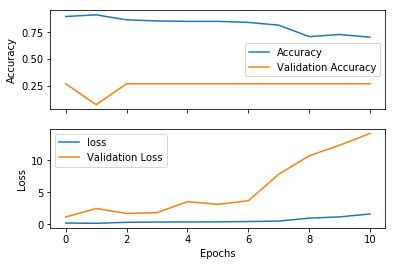

In [55]:
fig, (ax1,ax2) = plt.subplots(nrows=2,sharex='col',)

ax1.plot(hist.history["accuracy"])
ax1.plot(hist.history['val_accuracy'])
ax2.plot(hist.history['loss'])
ax2.plot(hist.history['val_loss'])
ax2.set_xlabel("Epochs")
ax1.legend(["Accuracy","Validation Accuracy"])
ax2.legend(["loss","Validation Loss"])
ax1.set_ylabel("Accuracy")
ax2.set_ylabel('Loss')

plt.show()
# plt.savefig("Model_4_weighted_Swish.png")

## Test Model

In [12]:
imagetype='.jpeg'
directory='all_xrays/test/'
subfolders=['normal','virus','bacteria']
class_labels=[0,1,1]

test_data,test_labels=dp.image_data_and_labels(imagetype, directory, subfolders, class_labels)
print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (1175, 224, 224, 3)
Total number of labels: (1175, 2)


In [ ]:
model_2.load_weights

In [13]:

model_predict = Sequential()

model_predict.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[0])
model_predict.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[1])
model_predict.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[2])
model_predict.add(VGG16(include_top=False, input_shape=(224,224,3)).layers[3])

model_predict.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name='Conv1_1'))
model_predict.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name='Conv1_2'))
model_predict.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool1'))

model_predict.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv2_1'))
model_predict.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv2_2'))
model_predict.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool2'))

model_predict.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv3_1'))
model_predict.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name='Conv3_2'))
model_predict.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool3'))

model_predict.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv4_1'))
model_predict.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv4_2'))
model_predict.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool4'))

model_predict.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv5_1'))
model_predict.add(BatchNormalization())
model_predict.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='Conv5_2'))
model_predict.add(BatchNormalization())
model_predict.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool5'))

model_predict.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv6_1'))
model_predict.add(BatchNormalization())
model_predict.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='Conv6_2'))
model_predict.add(BatchNormalization())
model_predict.add(MaxPool2D(pool_size=(2,2),strides=(2,2), name='Pool6'))

model_predict.add(Flatten(name="Flatten"))
model_predict.add(Dense(units=1024,activation="relu", name='Dense1'))
model_predict.add(Dense(units=512,activation="relu", name='Dense2'))
model_predict.add(Dense(units=2, activation="softmax", name='Result'))

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

opt = Adam(learning_rate=0.0005)
checkpoint = ModelCheckpoint("baseline.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

model_predict.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model_predict.fit(x=train_data,y=train_labels,epochs=0,callbacks=[checkpoint,early],class_weight={0:2.7,1:1})


# model_predict=load_model("Models/2 Class/Best model/Model_4_2class_datagen_OneOf.h5")

In [14]:
model_predict.load_weights('Models/2 Class/Weighted/Model_1_2class_weighted.h5')
from sklearn.metrics import confusion_matrix

preds = model_predict.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)
cm  = confusion_matrix(orig_test_labels, preds)
cm

ValueError: You are trying to load a weight file containing 19 layers into a model with 21 layers.

In [ ]:
tpr = cm[1][1]/(cm[1][0]+cm[1][1])
fpr = cm[0][0]/(cm[0][0]+cm[0][1])
acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])

tpr,fpr,acc

In [ ]:
# b1=np.zeros(100)
# count=0    
# while count<100:
#     b1[count] = 10
    
#     if count%2==0:
#         aug_img1 = 20
#         aug_img2 = 30
#         b1[count+1] = aug_img1
#         b1[count+2] = aug_img2

#         count +=3
#     else:
#         count+=1
    

#     print(b1)